4.	Build supervised machine learning model(s) to predict annual net savings based on other variables. Include appropriate safeguards against overfitting. Comment on the results. How well do the models perform? Is the performance stable? Are the models interpretable / explainable? Are these models suitable for decision-making? Is there enough signal in the data to build good models? Is there anything suspicious about the results?

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from pickle import dump

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import LinearRegression


In [2]:
# read the cleaned dataset 
df = pd.read_pickle('data/customer_data_modified.pkl')

In [3]:

input_num_variables = ['net_salary', 'other_income', 'housing_spend', 'childcare_spend', 'gambling_spend', 'credit_score', 'savings_bal_lbg', 'age']
# input_cat_variables = ['gender', 'ethnicity_group', 'geo_region']
input_cat_variables = ['gender_cat', 'ethnicity_group_cat', 'geo_region_cat']
all_input_variables = input_num_variables + input_cat_variables
target_var = 'annual_net_savings_lbg'

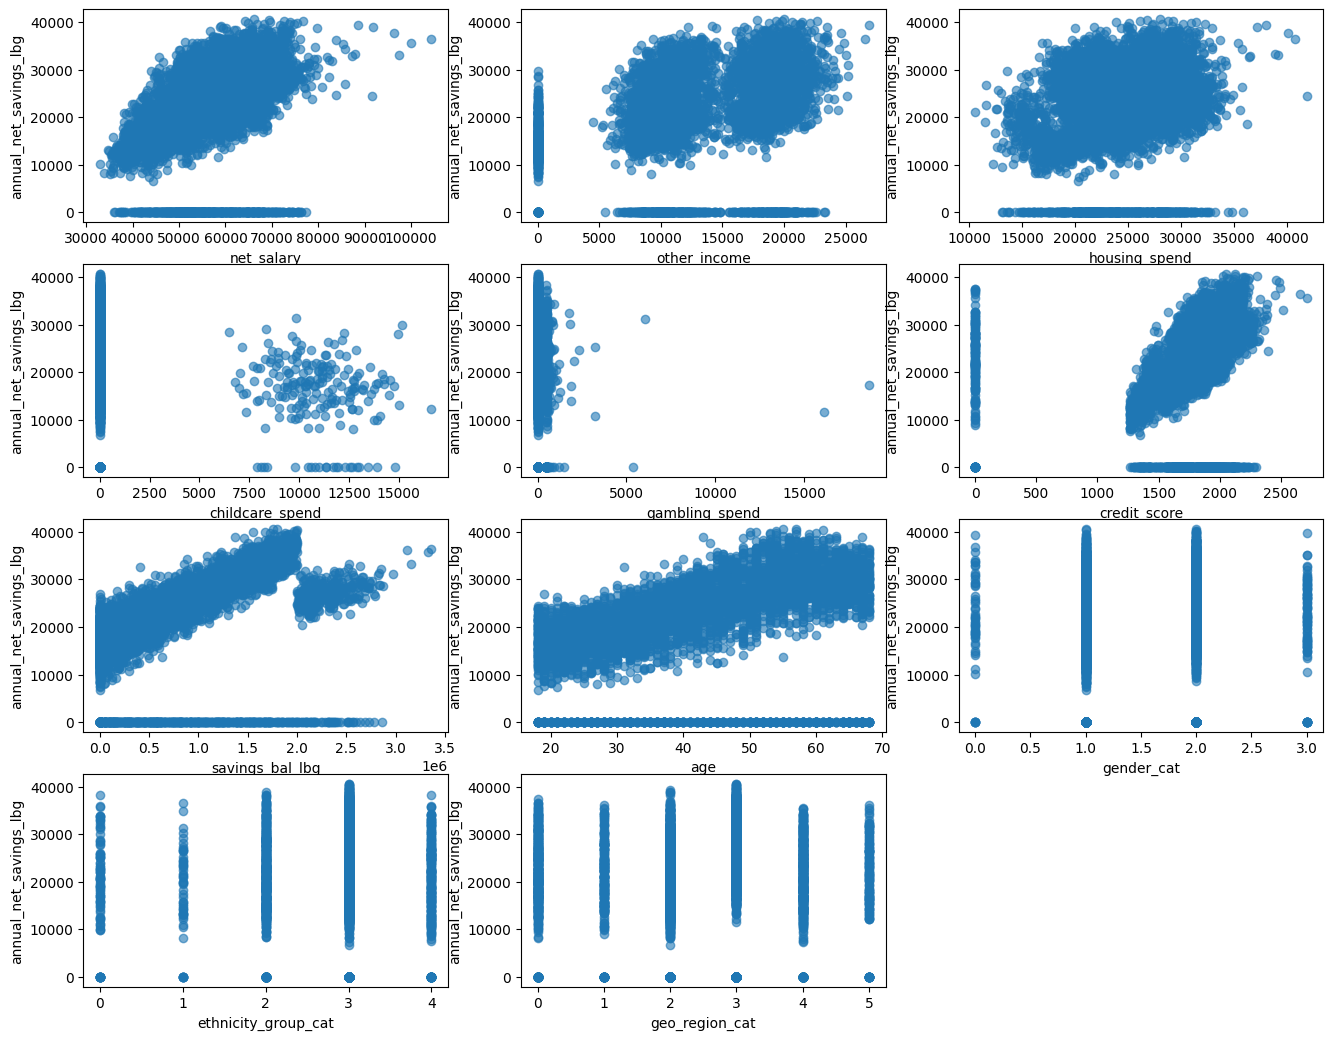

In [4]:
#check the variation of target variable with individual input variable
plt.figure(figsize=(16,16))
for i, var in enumerate(all_input_variables):
    plt.subplot(5,3,i+1)
    plt.scatter(df[var], df[target_var], alpha=0.6)
    plt.xlabel(var)
    plt.ylabel(target_var)

In [5]:
# predicting these net_savings = 0 values will be difficult 
# and model will not be stable 

df[df.annual_net_savings_lbg == 0.].cust_unique_id.count()

604

In [6]:
# drop these cases where annual net saving is zero

df = df[df.annual_net_savings_lbg !=0]

If its necessary to predict the cases where net savings will be 0, we should train a classifier to predict those cases 

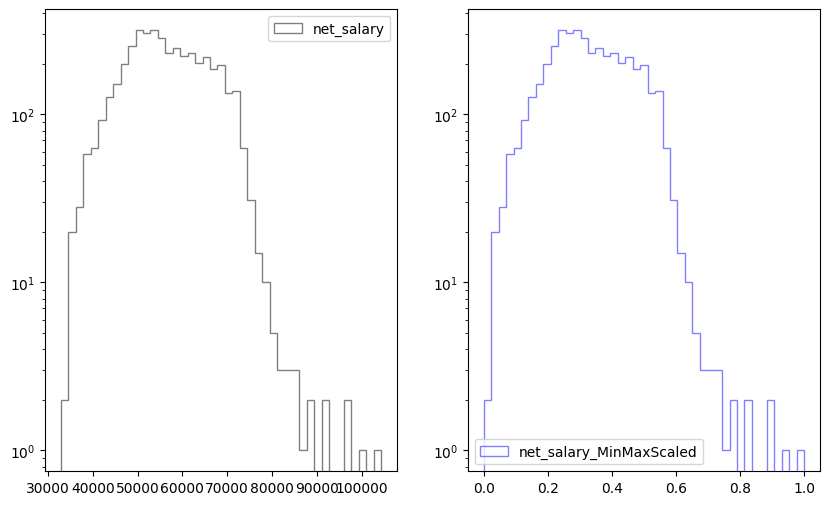

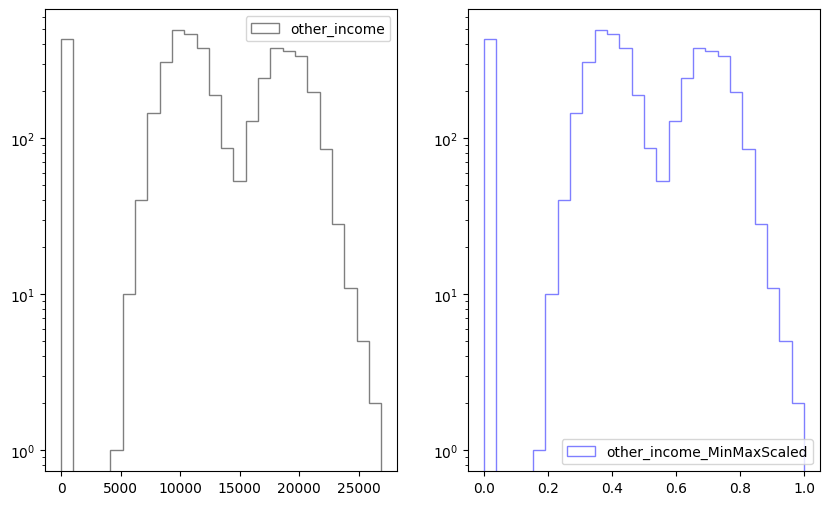

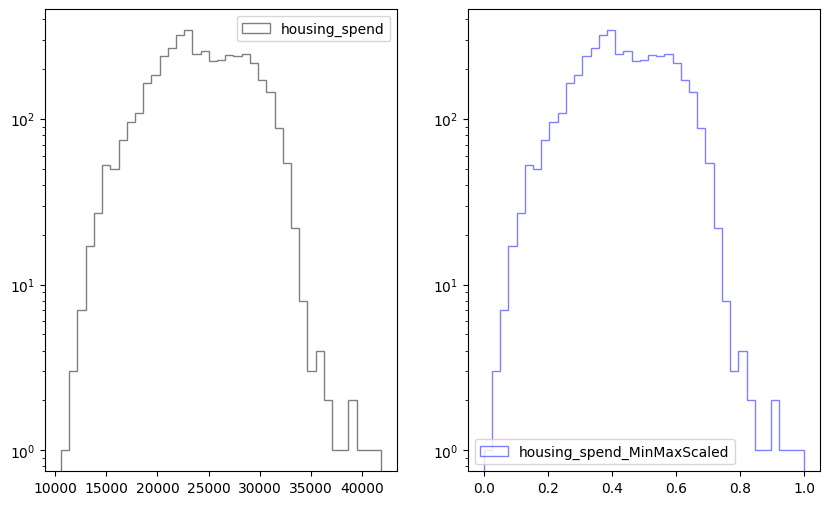

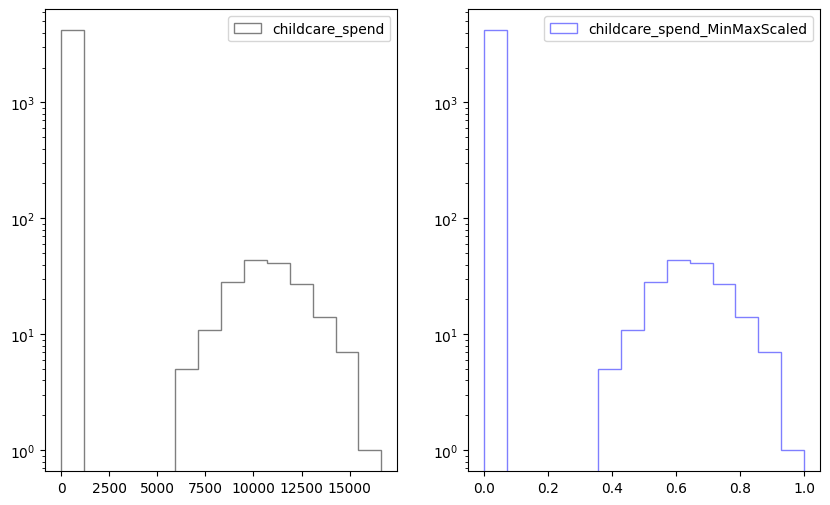

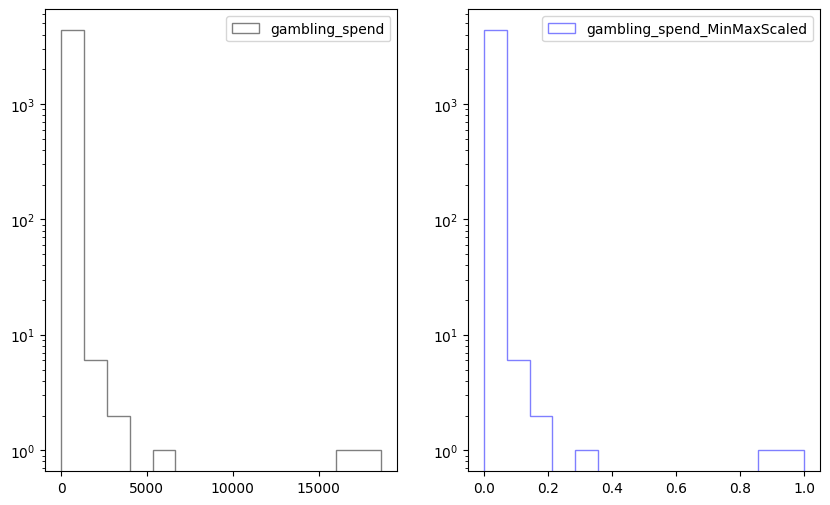

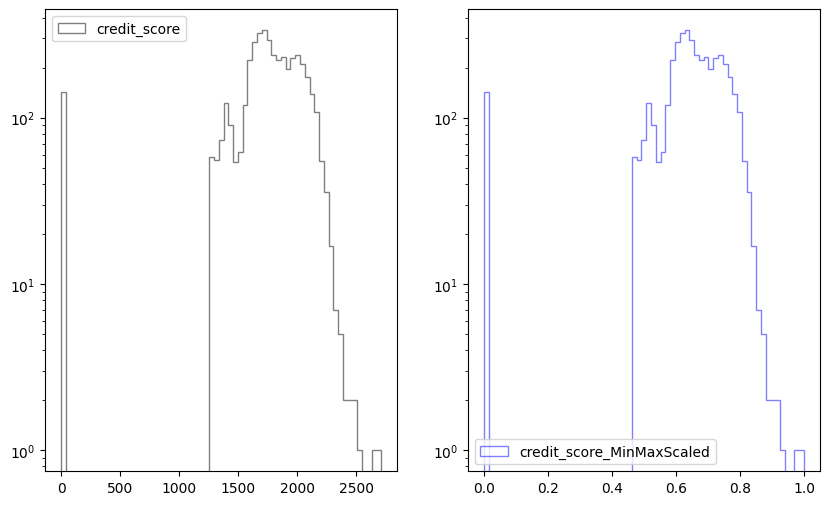

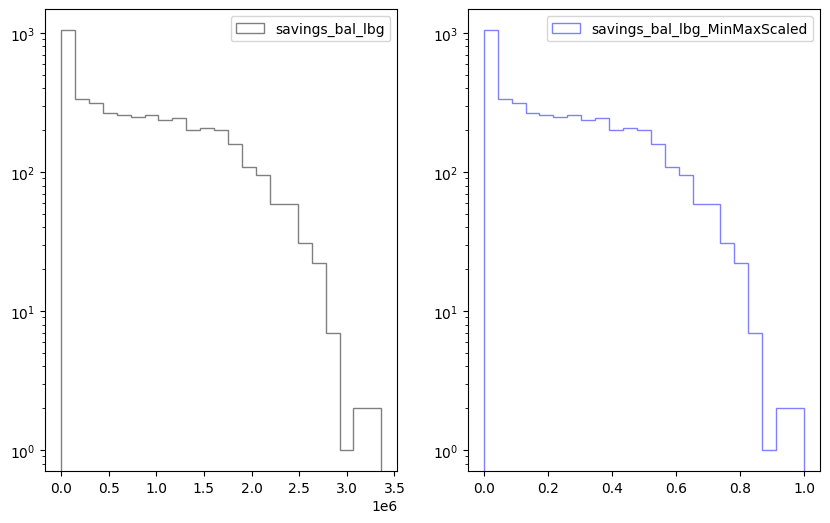

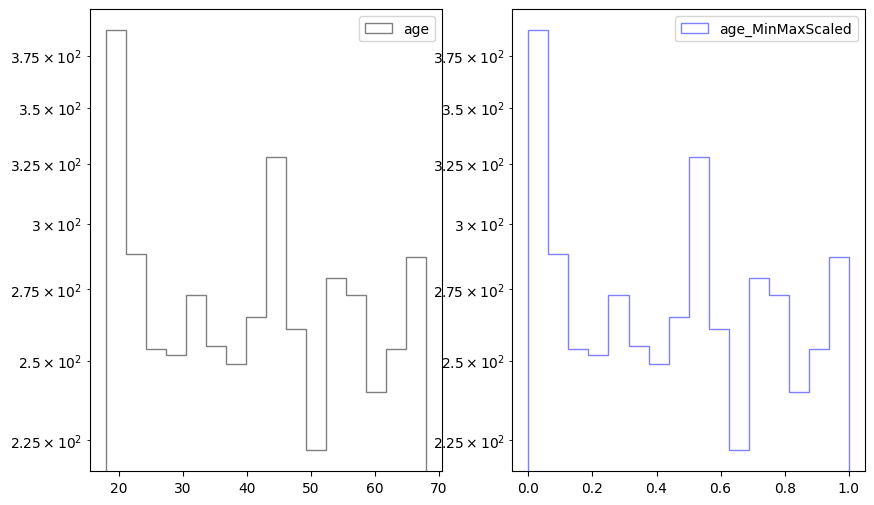

In [21]:
# since we have large scale in our numerical distribution, scaling the data with a MinMaxScalar will be suitable since it will preserve the shape of the distribution with values [0,1]
# lets check the transformed data to make sure
data_num_input = df[input_num_variables]
trans = MinMaxScaler().set_output(transform='pandas')
trans_data_num_input = trans.fit_transform(data_num_input)

for col in trans_data_num_input.columns:
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plt.hist(df[col], density=False, alpha=0.5, label=col,histtype='step', stacked=True, color='black', log=True, bins='auto')
    plt.legend()
    plt.subplot(122)
    plt.hist(trans_data_num_input[col], density=False, alpha=0.5, label=col+'_MinMaxScaled',histtype='step', stacked=True, color='blue', log=True, bins='auto')
    plt.legend()

Based on these distributions, <span style="color:green"> will choose MinMaxScaler</span>, however note that we will need to apply the same transformation to both train, test data - so will only derive the minmax scalar model by fitting only the training datasets

In [9]:
# define k-fold cross-validaton 
cvkfold = KFold(n_splits=10, random_state=42, shuffle=True)

In [10]:
# create a pipeline that will transform numerical features using minmax scaler for each fold, categorical ones are already labelled  

# def create_preprocessor_model_pipeline(numerical_features, categorical_features, model):
#     numeric_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])
#     categorical_trasnsformer = Pipeline(steps=[('encode', OneHotEncoder(handle_unknown='ignore'))])
#     preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features), ('cat', categorical_trasnsformer, categorical_features)])
#     preprocessor_model = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

#     return preprocessor_model

def create_preprocessor_model_pipeline(numerical_features, model):
    numeric_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])
    
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features)], remainder='passthrough')
    preprocessor_model = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    return preprocessor_model


In [11]:
def train_model(df, cv, preprocessor_model):
    train_datastets={}
    test_datasets={}
    models ={}
    predictions={}
    scores={}
    residuals={}
    mse={}


    for i, (train_index, test_index) in enumerate(cv.split(df)):
        fold = 'k_' + str(i)
        # print(i)
        # print(f'train_index {train_index}, shape: {train_index.shape}')
        # print(f'test_index: {test_index} shape: {test_index.shape}')
        # print(f'train_index: {df.iloc[train_index]}, test_index: {df.iloc[test_index]}')
        train_datastets[fold] = train_index
        test_datasets[fold] = test_index
        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
        models[fold] = preprocessor_model.fit(df_train[all_input_variables], df_train[target_var])
        scores[fold] = preprocessor_model.score(df_test[all_input_variables], df_test[target_var])
        predictions[fold] = preprocessor_model.predict(df_test[all_input_variables])
        residuals[fold] = np.subtract(predictions[fold], df_test[target_var])
        mse[fold] = mean_squared_error(df_test[target_var], predictions[fold] )
       

    return train_datastets, test_datasets, models, predictions, scores, residuals, mse

<span style="color:red"> Now to the choice of what model to use </span>. From our statistical modeling we already discovered the residuals are not normality distributed - so a linear regression might not be the best choice. Will still investigate


# Linear regression

In [12]:
lr = LinearRegression()
lr_pipeline = create_preprocessor_model_pipeline(input_num_variables, lr)
lr_train_datastets, lr_test_datasets, lr_models, lr_predictions, lr_scores, lr_residuals, lr_mse = train_model(df, cvkfold, lr_pipeline)


In [13]:
#R^2 scores
lr_scores

{'k_0': 0.7965496059986792,
 'k_1': 0.8070204968176515,
 'k_2': 0.7820591968313236,
 'k_3': 0.7651281487211944,
 'k_4': 0.8146070554395153,
 'k_5': 0.7852126046105161,
 'k_6': 0.8045422054383731,
 'k_7': 0.8046579461532637,
 'k_8': 0.7717173708144587,
 'k_9': 0.7993360716846598}

In [14]:
# mean square error 
lr_mse

{'k_0': 8780843.294049116,
 'k_1': 8806858.838372322,
 'k_2': 9845906.662042843,
 'k_3': 9288134.33681603,
 'k_4': 7637677.04365741,
 'k_5': 9716399.317804988,
 'k_6': 7797579.989248747,
 'k_7': 8245110.789031484,
 'k_8': 9124177.957777828,
 'k_9': 8993051.450961456}

<Axes: xlabel='annual_net_savings_lbg', ylabel='Count'>

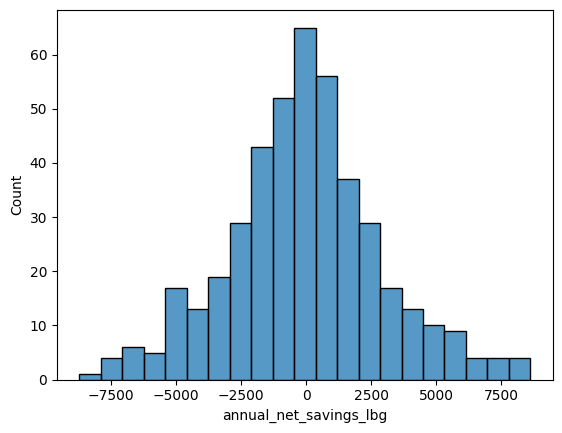

In [15]:
sns.histplot(lr_residuals['k_0'])

In [16]:
model_k0 = lr_models['k_0']['model']
model_k0.coef_

array([ 23290.65147799,   9795.28939715, -10162.96502306,  -5987.07785374,
        -8616.60158776,    322.25542729, -12570.03139232,  20518.23141156,
          196.31950629,   -170.04454704,    -28.93213609])